In [1]:
import numpy as np
import matplotlib.pyplot as pltx
#escalas
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#algoritmos 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model

from keras.src.models.sequential import Sequential
from keras.src.layers import Input,Dense
#métricas
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing #suavizado exponencial triple, que tiene en cuenta la estacionalidad
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import seaborn as sns 
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)


In [2]:
#df = pd.read_excel("/Users/pablomunozdelorenzo/Desktop/ventasEcommerce.xlsx")
df = pd.read_excel("dataset/ventasEcommerce.xlsx") #asumiendo que está en el mismo directorio donde se ejecuta el proyecto

In [3]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Order_Date.1', 'day', 'week',
       'QUINCENA', 'month', 'MES', 'year', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State',
       'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub_Category',
       'Product_Name', 'Total'],
      dtype='object')

In [4]:
# Aplicar One-Hot Encoding para convertir los datos en numéricos. 
df_correlacion = df[["MES","year","Segment","Region","Category","Total"]]
df_one_hot = pd.get_dummies(df_correlacion)


<Axes: >

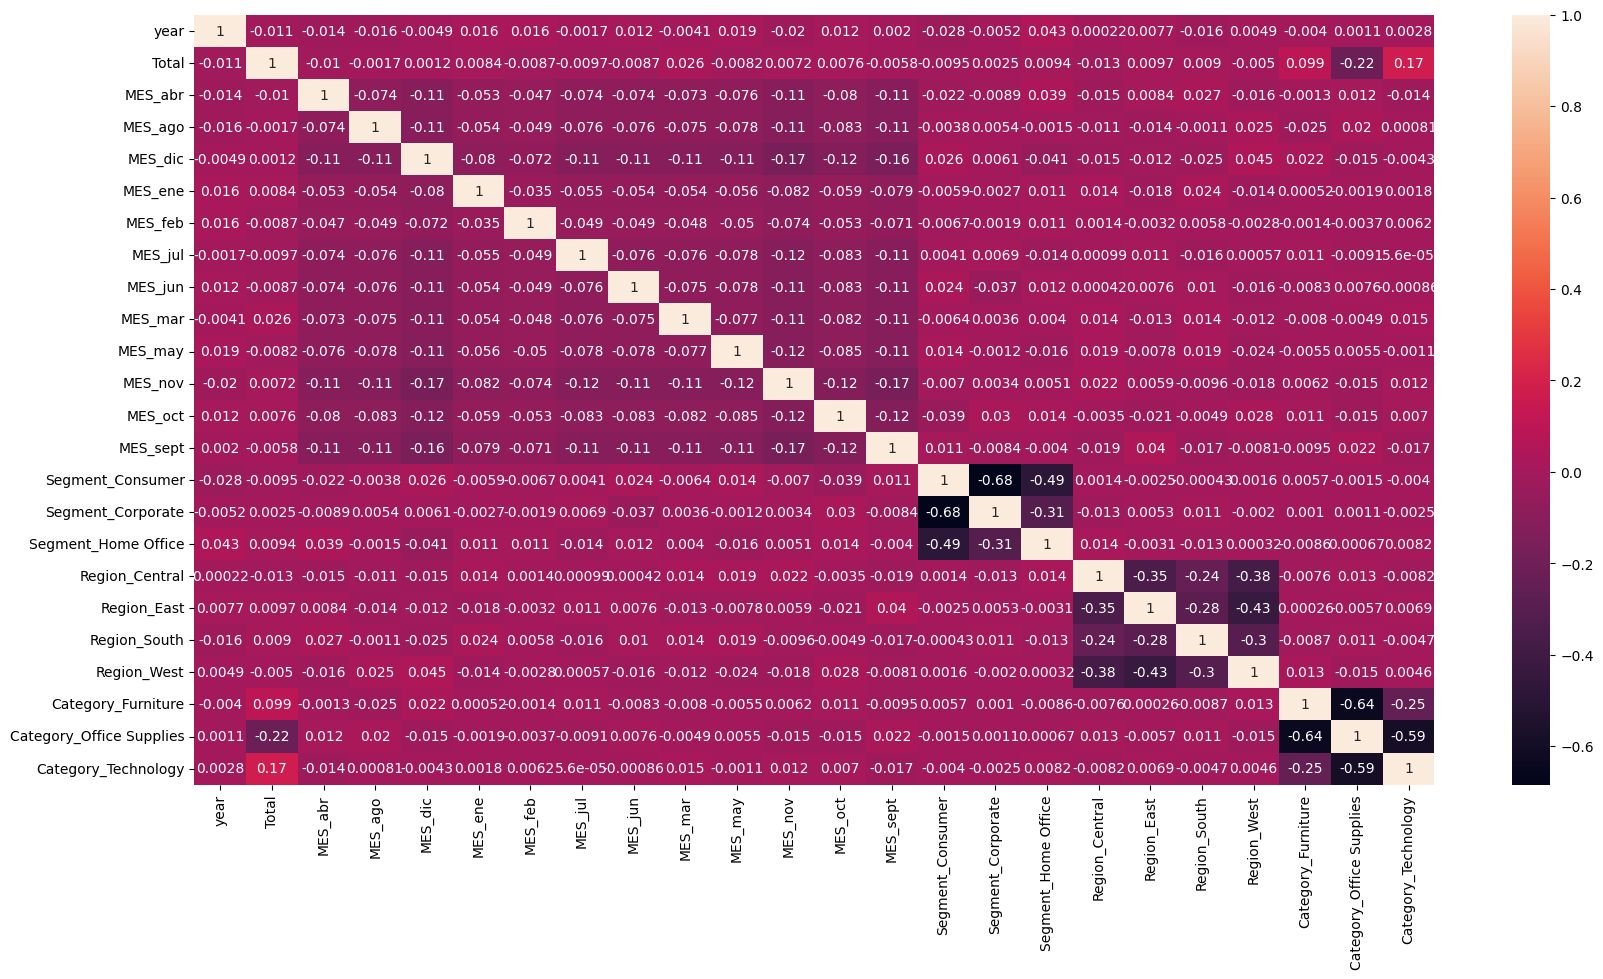

In [5]:
#comprobamos la correlación con el resto de campos. Se puede observar que ninguna de ellas es próxima a 1. 
pltx.figure(figsize=(20,10))
sns.heatmap(df_one_hot.corr(),annot=True)

In [6]:
#selecciono solo la columna fecha y saldo
df["Order_Date"] = pd.to_datetime(df["Order_Date"])
df2 = df[["Order_Date","Total"]]

In [7]:
df_resultadoVent = df2.resample("ME",on="Order_Date").sum() #ventas de entrenamiento
df_resultadoUni = df2.resample("ME",on="Order_Date").count() #unidades vendidas de entrenamiento

In [8]:
#mostramos la correlación entre las ventas y las unidades vendidas
np.corrcoef(df_resultadoVent["Total"],df_resultadoUni["Total"])

array([[1.        , 0.92812353],
       [0.92812353, 1.        ]])

In [9]:
X_train = df_resultadoUni[0:36] # tres primeros años de unidades vendidas
X_test = df_resultadoUni[36:48] #último año de unidades vendidas
Y_train = df_resultadoVent[0:36] # tres primeros años de ventas
Y_test = df_resultadoVent[36:48] #último año de ventas
Y_test

,Total
Order_Date,
2018-01-31,43476.4740
2018-02-28,19920.9974
2018-03-31,58863.4128
2018-04-30,35541.9101
2018-05-31,43825.9822
2018-06-30,48190.7277
2018-07-31,44825.1040
2018-08-31,62837.8480
2018-09-30,86152.8880


In [10]:
scalerVent = StandardScaler() #escalador de ventas
scalerUni = StandardScaler() #escalador para ingresos
X_trainEsc = scalerUni.fit_transform(X_train)#unidades vendidas 2015-2017 escaladas
X_testEsc = scalerUni.transform(X_test) #unidades vendidas 2018 escaladas
Y_trainEsc = scalerVent.fit_transform(Y_train) #ventas 2015-2017 escaladas
Y_testEsc = scalerVent.transform(Y_test)#ventas 2018 escaladas
X_testEsc

array([[-0.44882513],
       [-0.90086996],
       [ 0.64071881],
       [ 0.21185577],
       [ 0.67549149],
       [ 0.61753702],
       [ 0.4784463 ],
       [ 0.37412827],
       [ 3.14435169],
       [ 1.30139971],
       [ 3.17912437],
       [ 3.21389705]])

In [11]:
#comprobamos que el scaler funciona correctamente, comparando el resultado de la desescalación con los valoores reales. 
print(scalerUni.inverse_transform(X_testEsc))
print(df_resultadoUni[36:48])

[[143.]
 [104.]
 [237.]
 [200.]
 [240.]
 [235.]
 [223.]
 [214.]
 [453.]
 [294.]
 [456.]
 [459.]]
            Total
Order_Date       
2018-01-31    143
2018-02-28    104
2018-03-31    237
2018-04-30    200
2018-05-31    240
2018-06-30    235
2018-07-31    223
2018-08-31    214
2018-09-30    453
2018-10-31    294
2018-11-30    456
2018-12-31    459


In [12]:
#comprobamos la proporción entre datos de entrenamiento y test para la variable exógena y la endógena 
print(len(X_trainEsc)/(len(X_trainEsc)+len(X_testEsc)))
print(len(Y_trainEsc)/(len(Y_trainEsc) +len(Y_testEsc)))


0.75
0.75


In [13]:
#implantamos los modelos. Primero, probamos sobre los valores conocidos y analizamos el rendimiento de los modelos
#comenzamos por 1)regresión lineal
regr = linear_model.LinearRegression()
regr.fit(X_trainEsc,Y_trainEsc)
y_predRLEsc = regr.predict(X_testEsc)
#concatenamos la predicción a un array junto al valor original
resultado = np.concatenate((Y_testEsc,y_predRLEsc),axis=1)

In [14]:
#continuamos por 2)random forest
rf_model = RandomForestRegressor(n_estimators=100,random_state=4)
rf_model.fit(X_trainEsc, np.ravel(Y_trainEsc))
y_predRF = rf_model.predict(X_testEsc)
resultado = np.column_stack((resultado,y_predRF))
resultado

array([[ 0.03136463, -0.42119666, -0.52926227],
       [-1.00482077, -0.84541481, -0.98384632],
       [ 0.70822299,  0.60127787,  0.81138985],
       [-0.31767009,  0.19881449, -0.06037727],
       [ 0.0467392 ,  0.63391003,  0.81138985],
       [ 0.23874065,  0.57952309,  0.74759667],
       [ 0.09068972,  0.44899443,  0.37861428],
       [ 0.88305502,  0.35109793,  0.34317283],
       [ 1.90866382,  2.9507938 ,  1.50782507],
       [ 1.52574896,  1.22128902,  1.17920186],
       [ 3.30687071,  2.98342597,  1.50782507],
       [ 1.77130773,  3.01605813,  1.50782507]])

In [15]:
#comenzamos las predicciones de estacionalidad.
#Continuamos con 3)suavizado exponencial
modeloSE = ExponentialSmoothing(Y_train,seasonal_periods=12, trend='add', seasonal='add',initialization_method="estimated")
ajusteSE = modeloSE.fit()
y_predSE = ajusteSE.forecast(steps = len(Y_test))
y_predSE

2018-01-31     30407.728742
2018-02-28     30537.923623
2018-03-31     56151.893477
2018-04-30     51623.912188
2018-05-31     59040.531183
2018-06-30     47934.880339
2018-07-31     52952.619865
2018-08-31     54386.569946
2018-09-30     95633.395068
2018-10-31     55487.017431
2018-11-30    101054.618238
2018-12-31     96168.562128
Freq: ME, dtype: float64

In [16]:
#escalamos la nueva predicción y la añadimos al array
y_predSEEsc = scalerVent.transform(pd.DataFrame(y_predSE,columns=["Total"]))
resultado = np.column_stack((resultado,y_predSEEsc))

In [18]:
#Continuamos con el segundo modelo estacional
#En este caso, es 4)Sarimax. Primero ejecutamos la siguiente función, que nos indica cuál es el mejor ajuste del modelo en función del contexto
modeloSarimax = auto_arima(Y_train,start_p=0,d=1,start_q=0,
                         max_p=4,max_d=2,max_q=4,start_P=0,
                         D=1,start_Q=0,max_P=2,max_D=1, 
                        max_Q= 2,m=12, seasonal= True, error_action="warn",
                        trace= True, suppress_warnings=True, stepwise= True,
                        random_state= 20, n_fits=50)
print(modeloSarimax)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=514.796, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=508.768, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=507.790, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=515.262, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=508.871, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=509.375, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=509.370, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=510.395, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=507.867, Time=0.05 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=513.716, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
T

In [21]:
arima_model = SARIMAX(Y_train,exog=X_train,order=(0,1,1),seasonal_order=(0,1,1,12)).fit(method="bfgs")
y_predSarimax = arima_model.predict(start = "2018-01-01", end = "2018-12-30",exog = X_test ,typ="levels")
y_predSarimax

         Current function value: 6.772758
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51


2018-01-31     32720.416838
2018-02-28     24066.923235
2018-03-31     65745.437247
2018-04-30     44937.389453
2018-05-31     57004.678542
2018-06-30     50369.864359
2018-07-31     47127.701017
2018-08-31     43251.520060
2018-09-30    101577.928451
2018-10-31     74194.716617
2018-11-30    104467.510121
2018-12-31    117726.508225
Freq: ME, Name: predicted_mean, dtype: float64

In [22]:
y_predSarimaxEsc = scalerVent.transform(pd.DataFrame(y_predSarimax.values,columns=["Total"]))
resultado = np.column_stack((resultado,y_predSarimaxEsc))

In [23]:
resultado

array([[ 0.03136463, -0.42119666, -0.52926227, -0.54351837, -0.44178518],
       [-1.00482077, -0.84541481, -0.98384632, -0.53779121, -0.82244501],
       [ 0.70822299,  0.60127787,  0.81138985,  0.58894556,  1.0109574 ],
       [-0.31767009,  0.19881449, -0.06037727,  0.38976351,  0.09562906],
       [ 0.0467392 ,  0.63391003,  0.81138985,  0.71601428,  0.62645885],
       [ 0.23874065,  0.57952309,  0.74759667,  0.22748614,  0.33459902],
       [ 0.09068972,  0.44899443,  0.37861428,  0.44821224,  0.19197901],
       [ 0.88305502,  0.35109793,  0.34317283,  0.51129048,  0.0214691 ],
       [ 1.90866382,  2.9507938 ,  1.50782507,  2.32570327,  2.58719824],
       [ 1.52574896,  1.22128902,  1.17920186,  0.55969823,  1.38263402],
       [ 3.30687071,  2.98342597,  1.50782507,  2.56417827,  2.71430848],
       [ 1.77130773,  3.01605813,  1.50782507,  2.34924481,  3.29756054]])

In [24]:
#Por último implementamos el último modelo, 5)redes neuronales
model = Sequential()
model.add(Dense(64, input_shape=(1,), activation='relu'))   # Capa oculta con 64 neuronas y función de activación ReLU
model.add(Dense(1))  # Capa de salida con una neurona (predicción de ingresos)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # Compilar el modelo con el optimizador Adam y la pérdida MSE
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(X_trainEsc, Y_trainEsc, epochs=100, batch_size=32, validation_data=(X_testEsc, Y_testEsc))
predicciones_2018 = model.predict(X_testEsc)
resultado = np.column_stack((resultado, predicciones_2018))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0000e+00 - loss: 1.3171 - val_accuracy: 0.0000e+00 - val_loss: 2.6983
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 1.2643 - val_accuracy: 0.0000e+00 - val_loss: 2.5918
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 1.1885 - val_accuracy: 0.0000e+00 - val_loss: 2.4791
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 1.1331 - val_accuracy: 0.0000e+00 - val_loss: 2.3563
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 1.0782 - val_accuracy: 0.0000e+00 - val_loss: 2.2318
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 1.0620 - val_accuracy: 0.0000e+00 - val_loss: 2.1150
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.9800 - val_accuracy: 0.0000e+00 - val_loss: 2.0046
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 

In [26]:
df_predicciones = pd.DataFrame(resultado,index=df_resultadoVent[36:48].index.values,columns = ['Valor Real', 'Regresión Lineal', 'Random Forest', 'Suavización Exponencial', 'Sarimax',"Red Neuronal"])
df_predicciones

,Valor Real,Regresión Lineal,Random Forest,Suavización Exponencial,Sarimax,Red Neuronal
2018-01-31,0.031365,-0.421197,-0.529262,-0.543518,-0.441785,-0.554872
2018-02-28,-1.004821,-0.845415,-0.983846,-0.537791,-0.822445,-0.900630
2018-03-31,0.708223,0.601278,0.811390,0.588946,1.010957,0.803453
2018-04-30,-0.317670,0.198814,-0.060377,0.389764,0.095629,0.350288
2018-05-31,0.046739,0.633910,0.811390,0.716014,0.626459,0.828261
2018-06-30,0.238741,0.579523,0.747597,0.227486,0.334599,0.786187
2018-07-31,0.090690,0.448994,0.378614,0.448212,0.191979,0.675144
2018-08-31,0.883055,0.351098,0.343173,0.511290,0.021469,0.572875
2018-09-30,1.908664,2.950794,1.507825,2.325703,2.587198,2.365793
2018-10-31,1.525749,1.221289,1.179202,0.559698,1.382634,1.237828


In [27]:
r2RL = r2_score(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
r2RF = r2_score(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
r2Sarimax = r2_score(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
r2SE = r2_score(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
r2RN = r2_score(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])
mseRL = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
mseRF = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
mseSarimax = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
mseSE = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
mseRN = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])
maeRL = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
maeRF = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
maeSarimax = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
maeSE = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
maeRN = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])
mapeRL = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
mapeRF = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
mapeSarimax = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
mapeSE = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
mapeRN = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])

In [28]:
#calcular todos los errores (mae, mse, mape) y hacer una tablita
index = ["Coeficiente de determinación", "Error cuadrático medio","Error absoluto medio","Porcentaje de error absoluto medio"]
arrayMetrica = np.array([[r2RL, r2RF, r2Sarimax, r2SE, r2RN],
                  [mseRL, mseRF, mseSarimax, mseSE,mseRN],
                        [maeRL,maeRF,maeSarimax,maeSE,maeRN],
                        [mapeRL,mapeRF,mapeSarimax,mapeSE,mapeRN]]) #hecho con los valores nuevos de RF
df_metricas = pd.DataFrame(arrayMetrica,index=index,columns=['Regresión Lineal', 'Random Forest', 'Sarimax', 'Suavización Exponencial', "Redes Neuronales"])
df_metricas


,Regresión Lineal,Random Forest,Sarimax,Suavización Exponencial,Redes Neuronales
Coeficiente de determinación,0.727600,0.664055,0.691041,0.756258,0.760681
Error cuadrático medio,0.351119,0.433028,0.398243,0.314180,0.308479
Error absoluto medio,0.497366,0.487774,0.495873,0.498513,0.498258
Porcentaje de error absoluto medio,3.037836,3.521539,2.781913,3.443455,3.992300


In [29]:
#una vez tenemos predichos los ingresos de 2018, pasamos a predecir los de 2019. Para ello, entrenaremos el modelo con
#los datos entre 2016 a 2018, y en base a ellos predeciremos los de 2019 usando suavizado exponencial 
modeloSE2019 = ExponentialSmoothing(df_resultadoVent[12:48],seasonal_periods=12, trend='add', seasonal='add',initialization_method="estimated")
ajusteSE2019 = modeloSE2019.fit()
y_predSE2019 = ajusteSE2019.forecast(steps = len(df_resultadoVent[36:48]))
y_predSE2019 = pd.DataFrame(y_predSE2019, index= y_predSE2019.index.values,columns=["Total"])
y_predSE2019

,Total
2019-01-31,49682.408073
2019-02-28,40135.135966
2019-03-31,73568.403794
2019-04-30,55112.106270
2019-05-31,67276.278734
2019-06-30,60818.224836
2019-07-31,61453.022672
2019-08-31,61866.994373
2019-09-30,94522.396066
2019-10-31,73967.755768


In [30]:
dfy_predSE2019 = pd.DataFrame(y_predSE2019,columns = ["Total"])
df_resultadoVentFinal = pd.concat([df_resultadoVent, dfy_predSE2019])
df_resultadoVentFinal["month"] = df_resultadoVentFinal.index.month
df_resultadoVentFinal["year"] = df_resultadoVentFinal.index.year
df_resultadoVentFinal = df_resultadoVentFinal.pivot(index="month",columns="year",values="Total")
df_resultadoVentFinal

year,2015,2016,2017,2018,2019
month,,,,,
1,14205.7070,18066.9576,18542.4910,43476.4740,49682.408073
2,4519.8920,11951.4110,22978.8150,19920.9974,40135.135966
3,55205.7970,32339.3184,51165.0590,58863.4128,73568.403794
4,27906.8550,34154.4685,38679.7670,35541.9101,55112.106270
5,23644.3030,29959.5305,56656.9080,43825.9822,67276.278734
6,34322.9356,23599.3740,39724.4860,48190.7277,60818.224836
7,33781.5430,28608.2590,38320.7830,44825.1040,61453.022672
8,27117.5365,36818.3422,30542.2003,62837.8480,61866.994373
9,81623.5268,63133.6060,69193.3909,86152.8880,94522.396066


In [31]:
#una vez tenemos los ingresos de 2019, calculamos las ventas equivalentes. Usamos RN
#primero comprobamos que modelo usar, con los datos de 2018. No sirve la comparación anterior porque antes se había 
#trabajado con ventas y ahora se trabaja con unidades vendidas, por lo que los resultados pueden variar. 
#Comenzamos con la Red Neuronal
model = Sequential()
model.add(Dense(64, input_shape=(1,), activation='relu'))  # Capa oculta con 64 neuronas y función de activación ReLU
model.add(Dense(1))  # Capa de salida con una neurona (predicción de ingresos)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 
model.fit(Y_trainEsc, X_trainEsc, epochs=100, batch_size=32,validation_data=(Y_testEsc,X_testEsc))
prediccionesVentas_2018 = model.predict(Y_testEsc)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0000e+00 - loss: 0.7339 - val_accuracy: 0.0000e+00 - val_loss: 2.7331
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.6846 - val_accuracy: 0.0000e+00 - val_loss: 2.6400
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.6933 - val_accuracy: 0.0000e+00 - val_loss: 2.5504
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.6631 - val_accuracy: 0.0000e+00 - val_loss: 2.4667
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.6215 - val_accuracy: 0.0000e+00 - val_loss: 2.3861
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.6102 - val_accuracy: 0.0000e+00 - val_loss: 2.3114
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.5693 - val_accuracy: 0.0000e+00 - val_loss: 2.2432
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 

In [32]:
regr = linear_model.LinearRegression()
regr.fit(Y_trainEsc,X_trainEsc)
X_predRLEsc = regr.predict(Y_testEsc)

0.7387825657658229
0.4723071748924504


In [56]:
#comparar resultados de RN y RL
print("Coeficiente de determinación de Regresión lineal: ",r2_score(X_testEsc,X_predRLEsc))
print("Coeficiente de determinación de Red Neuronal:",r2_score(X_testEsc,prediccionesVentas_2018))
print("Error cuadrático medio de regresión lineal",mean_squared_error(X_testEsc,X_predRLEsc))
print("Error cuadrático medio de Red Neuronal",mean_squared_error(X_testEsc,prediccionesVentas_2018))

Coeficiente de determinación de Regresión lineal:  0.7387825657658229
Coeficiente de determinación de Red Neuronal: 0.6972355172693774
Error cuadrático medio de regresión lineal 0.4723071748924504
Error cuadrático medio de Red Neuronal 0.5474283824718961


In [33]:
#Se ha comprobado que la Regresión lineal ofrece mejores resultados. 
#A continuación, preparamos los datos. Entrenaremos al modelo con datos de 2016 a 2018 para predecir 2019
X_trainP = np.concatenate((X_trainEsc[12:36],X_testEsc))#unidades vendidas 2016-2018
Y_trainP = np.concatenate((Y_trainEsc[12:36],Y_testEsc))#ventas 2016-2018
Y_testP = scalerVent.transform(pd.DataFrame(y_predSE2019,columns = ["Total"]))#ventas 2019
Y_testP

array([[ 0.3043584 ],
       [-0.11561799],
       [ 1.35508305],
       [ 0.54320621],
       [ 1.07829782],
       [ 0.79421351],
       [ 0.82213773],
       [ 0.840348  ],
       [ 2.27683137],
       [ 1.37265021],
       [ 2.7994478 ],
       [ 3.15452119]])

In [34]:
regr = linear_model.LinearRegression()
regr.fit(Y_trainP,X_trainP)
X_predRLEsc2019 = regr.predict(Y_testP)
X_predRL2019 = np.round(scalerUni.inverse_transform(X_predRLEsc2019))
X_predRL2019 = pd.DataFrame(X_predRL2019,index = y_predSE2019.index, columns=["Total"])
X_predRL2019

,Total
2019-01-31,219.0
2019-02-28,180.0
2019-03-31,315.0
2019-04-30,241.0
2019-05-31,289.0
2019-06-30,264.0
2019-07-31,266.0
2019-08-31,268.0
2019-09-30,399.0
2019-10-31,316.0


In [35]:
#a partir de las unidades vendidas para 2019, se obtienen las unidades vendidas por categoría. 
#primero se preparan los datos, para desglosar las unidades vendidas totales de los años pasados por categoría
df3 = df[["Order_Date", "Total", "Category"]].copy()
df3['Technology'] = (df3['Category'] == 'Technology').astype(int)
df3['Office Supplies'] = (df3['Category'] == 'Office Supplies').astype(int)
df3['Furniture'] = (df3['Category'] == 'Furniture').astype(int)
# Mostrar el resultado
df3

,Order_Date,Total,Category,Technology,Office Supplies,Furniture
0,2015-01-03,16.448,Office Supplies,0,1,0
1,2015-01-04,11.784,Office Supplies,0,1,0
2,2015-01-04,272.736,Office Supplies,0,1,0
3,2015-01-04,3.540,Office Supplies,0,1,0
4,2015-01-05,19.536,Office Supplies,0,1,0
...,...,...,...,...,...,...
9795,2018-12-30,90.930,Technology,1,0,0
9796,2018-12-30,52.776,Office Supplies,0,1,0
9797,2018-12-30,13.904,Office Supplies,0,1,0
9798,2018-12-30,20.720,Office Supplies,0,1,0


In [36]:
#se continua la preparación de los datos
df3['Order_Date'] = pd.to_datetime(df3['Order_Date'])
df_resultadoVent2 = df_resultadoVent
df_resultadoUni2 = df3.groupby('Category').resample('M', on='Order_Date').size()
df_resultadoUni2 = df_resultadoUni2.unstack(level=0)
df_resultadoUni2['Ventas Totales'] = df3.resample('M', on='Order_Date')['Total'].count()
df_resultadoUni2 = pd.DataFrame(df_resultadoUni2.values, columns = df_resultadoUni2.columns, index = df_resultadoUni2.index.values)
print("Unidades vendidas por categoría:")
print(df_resultadoVent2)
print("\nVentas por categoría:")
print(df_resultadoUni2)

Unidades vendidas por categoría:
                  Total
Order_Date             
2015-01-31   14205.7070
2015-02-28    4519.8920
2015-03-31   55205.7970
2015-04-30   27906.8550
2015-05-31   23644.3030
2015-06-30   34322.9356
2015-07-31   33781.5430
2015-08-31   27117.5365
2015-09-30   81623.5268
2015-10-31   31453.3930
2015-11-30   77907.6607
2015-12-31   68167.0585
2016-01-31   18066.9576
2016-02-29   11951.4110
2016-03-31   32339.3184
2016-04-30   34154.4685
2016-05-31   29959.5305
2016-06-30   23599.3740
2016-07-31   28608.2590
2016-08-31   36818.3422
2016-09-30   63133.6060
2016-10-31   31011.7375
2016-11-30   75249.3995
2016-12-31   74543.6012
2017-01-31   18542.4910
2017-02-28   22978.8150
2017-03-31   51165.0590
2017-04-30   38679.7670
2017-05-31   56656.9080
2017-06-30   39724.4860
2017-07-31   38320.7830
2017-08-31   30542.2003
2017-09-30   69193.3909
2017-10-31   59583.0330
2017-11-30   79066.4958
2017-12-31   95739.1210
2018-01-31   43476.4740
2018-02-28   19920.9974
2018-03

In [37]:
scalerUniRF = StandardScaler() #se usa un nuevo escalador para las unidades vendidas, porque tiene una dimensión distinta que el dataframe anterior. 
df_resultadoUniEsc2 = scalerUniRF.fit_transform(df_resultadoUni2)
X_trainEsc2 = df_resultadoUniEsc2[0:36] # tres primeros años de unidades vendidas por categoría
X_testEsc2 = df_resultadoUniEsc2[36:48] #último año de unidades vendidas por categoría

In [38]:
PorcentajeTecnología = df_resultadoUni2["Technology"] / df_resultadoUni2["Ventas Totales"]
PorcentajeOfficeSupplies = df_resultadoUni2["Office Supplies"] / df_resultadoUni2["Ventas Totales"]
PorcentajeFurniture = df_resultadoUni2["Furniture"] / df_resultadoUni2["Ventas Totales"]
array_concatenado = np.column_stack((PorcentajeTecnología,PorcentajeOfficeSupplies,PorcentajeFurniture))
pdArray_concatenado = pd.DataFrame(array_concatenado,index=df_resultadoUni2.index.values,columns=["Technology","Office Supplies","Furniture"])
pdArray_concatenado

,Technology,Office Supplies,Furniture
2015-01-31,0.116883,0.636364,0.246753
2015-02-28,0.173913,0.673913,0.152174
2015-03-31,0.136364,0.655844,0.207792
2015-04-30,0.184615,0.615385,0.200000
2015-05-31,0.223140,0.578512,0.198347
2015-06-30,0.160305,0.618321,0.221374
2015-07-31,0.190141,0.577465,0.232394
2015-08-31,0.178082,0.664384,0.157534
2015-09-30,0.168539,0.621723,0.209738
2015-10-31,0.188679,0.610063,0.201258


In [39]:
#una vez tenemos las ventas de 2019 y los datos preparados, calculamos las ventas de cada categoría
pdArray_concatenadoTrain = pdArray_concatenado[12:48] #porcentajes unidades vendidas 2016-2018
df_resultadoVent2 = df_resultadoVent2[12:48] # ventas 2016-2018

In [40]:
#predecimos las ventas por categoría, en función de las ventas de 2019
scalerUniCat = StandardScaler()
UniCatEsc = scalerUniCat.fit_transform(pdArray_concatenadoTrain)
regr = linear_model.LinearRegression()
regr.fit(X_trainP,UniCatEsc) 
X_predRLCatEsc = regr.predict(X_predRLEsc2019) #porcentajes por categoría 2019
X_predRLCatEsc

array([[-1.34105725e-03,  1.16206653e-03, -1.09706603e-04],
       [ 6.55941763e-02, -5.68393309e-02,  5.36600078e-03],
       [-1.68804044e-01,  1.46273792e-01, -1.38091929e-02],
       [-3.94082782e-02,  3.41484609e-02, -3.22383576e-03],
       [-1.24690411e-01,  1.08047999e-01, -1.02004306e-02],
       [-7.94134624e-02,  6.88141589e-02, -6.49650205e-03],
       [-8.38639840e-02,  7.26706700e-02, -6.86058167e-03],
       [-8.67663097e-02,  7.51856227e-02, -7.09800948e-03],
       [-3.15710967e-01,  2.73573069e-01, -2.58270686e-02],
       [-1.71603872e-01,  1.48699927e-01, -1.40382357e-02],
       [-3.99004823e-01,  3.45749706e-01, -3.26410104e-02],
       [-4.55595910e-01,  3.94787589e-01, -3.72705040e-02]])

In [41]:
X_predRLCat = scalerUniCat.inverse_transform(X_predRLCatEsc)
X_predRLCat = pd.DataFrame(X_predRLCat,index = y_predSE2019.index,columns = pdArray_concatenado.columns)
X_predRLCat

,Technology,Office Supplies,Furniture
2019-01-31,0.189579,0.598149,0.212272
2019-02-28,0.191658,0.595906,0.212436
2019-03-31,0.184376,0.603761,0.211863
2019-04-30,0.188396,0.599425,0.212179
2019-05-31,0.185746,0.602283,0.211971
2019-06-30,0.187153,0.600765,0.212082
2019-07-31,0.187015,0.600915,0.212071
2019-08-31,0.186925,0.601012,0.212064
2019-09-30,0.179812,0.608684,0.211504
2019-10-31,0.184289,0.603855,0.211856


In [42]:
#multiplicamos las predicciones de porcentajes de cada categoría por las ventas totales de 2019 para calcular las ventas mensuales de 2019 por categoría
prediccionUnidades2019Cat = np.round(X_predRL2019.values * X_predRLCat.values)
prediccionUnidades2019Cat = pd.DataFrame(prediccionUnidades2019Cat,index = y_predSE2019.index, columns = pdArray_concatenado.columns)
prediccionUnidades2019Cat

,Technology,Office Supplies,Furniture
2019-01-31,42.0,131.0,46.0
2019-02-28,34.0,107.0,38.0
2019-03-31,58.0,190.0,67.0
2019-04-30,45.0,144.0,51.0
2019-05-31,54.0,174.0,61.0
2019-06-30,49.0,159.0,56.0
2019-07-31,50.0,160.0,56.0
2019-08-31,50.0,161.0,57.0
2019-09-30,72.0,243.0,84.0
2019-10-31,58.0,191.0,67.0


In [43]:
#ventas por categoría
#se hace una predicción con las unidades vendidas por categoría para obtener ventas por categoría. Tengo que obtener los ingresos por categoría entre 2016 y 2018
df_resultadoVent2 = df3.groupby('Category').resample("ME",on="Order_Date").sum() #ingresos de entrenamiento
df_resultadoVent2 = df_resultadoVent2[["Total"]]
df_resultadoVent2 = df_resultadoVent2.unstack(level=0)
df_resultadoVent2.columns = df_resultadoVent2.columns.droplevel(0)
df_resultadoVent2 = df_resultadoVent2[["Technology","Office Supplies","Furniture"]]
df_resultadoVent2["Total"] = df_resultadoVent
df_resultadoVent2


Category,Technology,Office Supplies,Furniture,Total
Order_Date,,,,
2015-01-31,3143.290,4845.140,6217.2770,14205.7070
2015-02-28,1608.510,1071.724,1839.6580,4519.8920
2015-03-31,32359.974,8602.455,14243.3680,55205.7970
2015-04-30,8973.144,10988.874,7944.8370,27906.8550
2015-05-31,9599.876,7131.640,6912.7870,23644.3030
2015-06-30,8435.965,12742.389,13144.5816,34322.9356
2015-07-31,7839.284,15121.208,10821.0510,33781.5430
2015-08-31,8937.050,11055.276,7125.2105,27117.5365
2015-09-30,30383.748,27423.298,23816.4808,81623.5268


In [44]:
#volvemos a predecir, usando RL
PorcentajeTecnología2 = df_resultadoVent2["Technology"] / df_resultadoVent2["Total"]
PorcentajeOfficeSupplies2 = df_resultadoVent2["Office Supplies"] / df_resultadoVent2["Total"]
PorcentajeFurniture2 = df_resultadoVent2["Furniture"] / df_resultadoVent2["Total"]
#calcular a partir del porcentaje y luego ponderar
array_concatenado2 = np.column_stack((PorcentajeTecnología2,PorcentajeOfficeSupplies2,PorcentajeFurniture2))
pdArray_concatenado2 = pd.DataFrame(array_concatenado2,index=df_resultadoVent2.index.values,columns=["Technology","Office Supplies","Furniture"])
#preparamos los datos. Necesitamos Ventas porcentaje entrenamiento y unidades vendidas todo
pdArray_concatenado2Train = pdArray_concatenado2[12:48] #porcentajes ventas 2016-2018
UniCatTrain = df_resultadoUni2[["Technology","Office Supplies","Furniture"]][12:48] #unidades vendidas por categoría 2016 a 2018
UniCatTest = prediccionUnidades2019Cat #unidades vendidas por categoría 2019 (predicción anterior)
scalerVentCat = StandardScaler() #escalador ventas por categoría porcentaje
scalerUniCat2 = StandardScaler() #escalador unidades vendidas por categoría, esta vez como valor entero y no porcentaje
scalerVentCat2 = StandardScaler() #escalador ventas por categoría, esta vez como valor entero y no como porcentaje
#escalamos los datos
UniCatTrainEsc = scalerUniCat2.fit_transform(UniCatTrain)
UniCatTestEsc =  scalerUniCat2.transform(UniCatTest)
pdArray_concatenado2TrainEsc = scalerVentCat.fit_transform(pdArray_concatenado2Train)
#predecimos los ingresos por categoría de 2019
modelRNVentCat2019 = Sequential()
modelRNVentCat2019.add(Dense(64, input_shape=(3,), activation='relu'))  # Capa oculta con 64 neuronas, tres entradas y función de activación ReLU
modelRNVentCat2019.add(Dense(3))  # Capa de salida con una neurona (predicción de ingresos)
modelRNVentCat2019.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 
modelRNVentCat2019.fit(UniCatTrainEsc, pdArray_concatenado2TrainEsc, epochs=100, batch_size=32)
predVentCat2019RNEsc = modelRNVentCat2019.predict(UniCatTestEsc)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4236 - loss: 1.0742  
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4236 - loss: 1.1185
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4132 - loss: 1.0676
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4236 - loss: 1.0783
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4028 - loss: 1.0701 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4340 - loss: 1.0581 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4236 - loss: 1.0597
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4815 - loss: 1.0594 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4711 - loss: 1.0525
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4317 - loss: 1.0542
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4132 - loss: 1.0361
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4236 - loss: 1.0

In [47]:
predVentCat2019RN = scalerVentCat.inverse_transform(predVentCat2019RNEsc)
predVentCat2019RN = pd.DataFrame(predVentCat2019RN,columns=X_predRLCat.columns, index = X_predRLCat.index.values)
#una vez tenemos los porcentajes predichos, los multiplicamos por los ingresos de 2019 para desglosar los ingresos por categoría
predVentCat2019 = np.round(y_predSE2019.values * predVentCat2019RN.values)
predVentCat2019 = pd.DataFrame(predVentCat2019,columns = prediccionUnidades2019Cat.columns, index = prediccionUnidades2019Cat.index.values)
predVentCat2019

,Technology,Office Supplies,Furniture
2019-01-31,18807.0,15126.0,15482.0
2019-02-28,14632.0,12679.0,12623.0
2019-03-31,26306.0,22312.0,24842.0
2019-04-30,20560.0,16654.0,17695.0
2019-05-31,24530.0,20292.0,22248.0
2019-06-30,22375.0,18413.0,19875.0
2019-07-31,22716.0,18526.0,19983.0
2019-08-31,22752.0,18701.0,20253.0
2019-09-30,32101.0,29023.0,33363.0
2019-10-31,26413.0,22460.0,24983.0


In [48]:
#obtener ingresos totales 5 años, ventas totales 5 años, ventas categoría 5 años, e ingresos por categoría 5 años
#ingresos por categoría 5 años
VentCatFinal = pd.concat([df_resultadoVent2, predVentCat2019], axis=0) #ventas totales 5 años
UniCatFinal = pd.concat([df_resultadoUni2[["Technology","Office Supplies","Furniture"]].astype(int), prediccionUnidades2019Cat.astype(int)], axis=0)
VentFinal = pd.concat([df_resultadoVent, dfy_predSE2019])
UniFinal = pd.concat([df_resultadoUni.astype(int), X_predRL2019.astype(int)])
VentCatFinal

,Technology,Office Supplies,Furniture,Total
2015-01-31,3143.290,4845.140,6217.2770,14205.7070
2015-02-28,1608.510,1071.724,1839.6580,4519.8920
2015-03-31,32359.974,8602.455,14243.3680,55205.7970
2015-04-30,8973.144,10988.874,7944.8370,27906.8550
2015-05-31,9599.876,7131.640,6912.7870,23644.3030
2015-06-30,8435.965,12742.389,13144.5816,34322.9356
2015-07-31,7839.284,15121.208,10821.0510,33781.5430
2015-08-31,8937.050,11055.276,7125.2105,27117.5365
2015-09-30,30383.748,27423.298,23816.4808,81623.5268
2015-10-31,11938.018,7211.128,12304.2470,31453.3930


In [49]:
VentFinal

,Total
2015-01-31,14205.707000
2015-02-28,4519.892000
2015-03-31,55205.797000
2015-04-30,27906.855000
2015-05-31,23644.303000
2015-06-30,34322.935600
2015-07-31,33781.543000
2015-08-31,27117.536500
2015-09-30,81623.526800
2015-10-31,31453.393000


In [50]:
UniCatFinal

,Technology,Office Supplies,Furniture
2015-01-31,9,49,19
2015-02-28,8,31,7
2015-03-31,21,101,32
2015-04-30,24,80,26
2015-05-31,27,70,24
2015-06-30,21,81,29
2015-07-31,27,82,33
2015-08-31,26,97,23
2015-09-30,45,166,56
2015-10-31,30,97,32


In [51]:
UniFinal

,Total
2015-01-31,77
2015-02-28,46
2015-03-31,154
2015-04-30,130
2015-05-31,121
2015-06-30,131
2015-07-31,142
2015-08-31,146
2015-09-30,267
2015-10-31,159


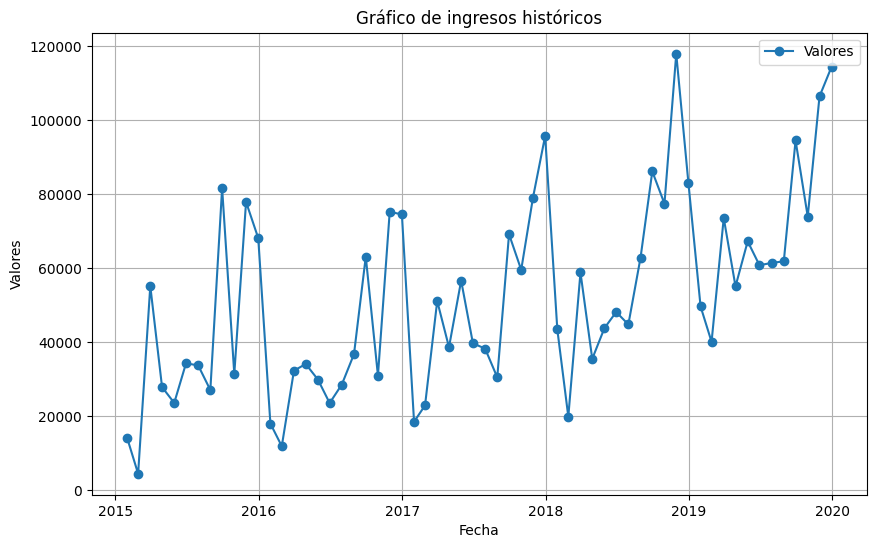

In [53]:
pltx.figure(figsize=(10, 6))
pltx.plot(VentFinal.index, VentFinal['Total'], label='Valores', marker='o')

# Agregar etiquetas y título
pltx.xlabel('Fecha')
pltx.ylabel('Valores')
pltx.title('Gráfico de ingresos históricos')
pltx.legend()
pltx.grid(True)

# Mostrar el gráfico
pltx.show()

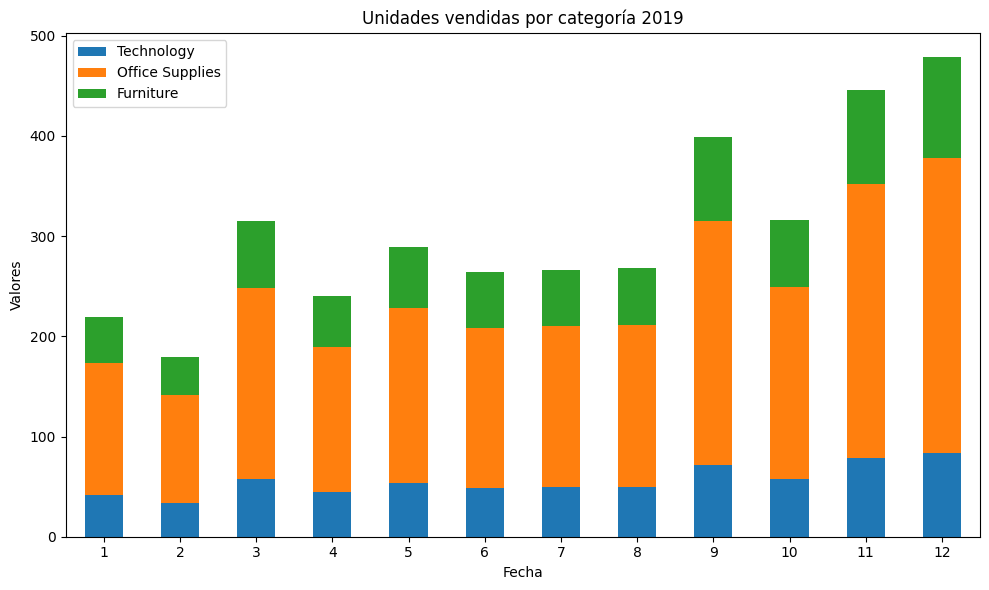

In [54]:
# Crear el gráfico de columnas apiladas
ax = prediccionUnidades2019Cat.astype(int).plot(kind='bar', stacked=True, figsize=(10, 6))

# Agregar etiquetas y título
ax.set_xticklabels(prediccionUnidades2019Cat.index.month,rotation=0)
pltx.xlabel('Fecha')
pltx.ylabel('Valores')
pltx.title('Unidades vendidas por categoría 2019')

# Mostrar el gráfico
pltx.tight_layout()
pltx.show()